In [2]:
import pandas as pd 
import numpy as np
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.graphics.regressionplots import plot_leverage_resid2

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
import math

In [3]:
def forward_selection(data, significance_level=0.01): #Selecting significant features, removing TEAM, CONF and W:G manually
  
  target = data["W:G"].to_numpy()
  features = data.columns.tolist()
  lowest_p_value = 0
  lowest_p_index = -1
  for i in range(len(features)):
    if (features[i] == "TEAM" or features[i] == "CONF" or features[i] == "W:G"):
      continue
    X = data.loc[:, features[i]]
    X = sm.add_constant(X)
    result = sm.OLS(target, X.astype(float)).fit()
    curr_p_value = result.pvalues[1]
    if lowest_p_index == -1 or lowest_p_value > curr_p_value:
        lowest_p_value = curr_p_value
        lowest_p_index = i

  removed_features = [data.loc[:, features.pop(lowest_p_index)].name]
  while (True):
      lowest_p_value = 0
      lowest_p_index = -1
      for i in range(len(features)):
        if (features[i] == "TEAM" or features[i] == "CONF" or features[i] == "W:G"):
          continue
        removed_features.append(features[i])
        X = data.loc[:, removed_features]
        X = sm.add_constant(X)
        result = sm.OLS(target, X.astype(float)).fit()
        removed_features.remove(features[i])
        curr_value = result.pvalues[len(result.pvalues) - 1]
        if lowest_p_index == -1 or lowest_p_value > curr_value:
            lowest_p_value = curr_value
            lowest_p_index = i
    
      if (lowest_p_value >= significance_level):
        return removed_features
      else:
        if (len(features) == 0):
            break
        removed_features.append(features.pop(lowest_p_index))
          
  return removed_features

In [4]:
def top_features(columns, size): # Return the most important features from forward selection
    return columns[:size]

In [5]:
def linear_regression(X, y):
    model = sm.OLS(y, X)
    results = model.fit()
    return results

In [6]:
def display_summary(results):
    print(results.summary())

In [7]:
"""
Load the preprocessed dataset
"""
csv_name = 'cleaned_cbb.csv'
data = pd.read_csv(csv_name)

In [8]:
"""
Select the top features from forward selection
"""
fwd_sel = forward_selection(data)
important_features = top_features(fwd_sel, 5)
print(important_features)
X = data[important_features]
y = data["W:G"]

['ADJOE', 'WAB', 'EFG_O', 'TOR', 'ORB']


In [9]:
"""
Split the dataset into a training and testing set
"""
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [10]:
"""
Perform supervised learning to predict the win rate using selected features with Ordinary Linear Regression
"""
model = linear_regression(X_train, y_train)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    W:G   R-squared (uncentered):                   0.985
Model:                            OLS   Adj. R-squared (uncentered):              0.985
Method:                 Least Squares   F-statistic:                          2.545e+04
Date:                Tue, 05 Apr 2022   Prob (F-statistic):                        0.00
Time:                        14:54:23   Log-Likelihood:                          2542.7
No. Observations:                1964   AIC:                                     -5075.
Df Residuals:                    1959   BIC:                                     -5048.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
ADJOE         -0.0117      0.000    -25.447      0.000      -0.013      -0.011
WAB            0.0203      0.000     70.006      0.000       0.020       0.021
EFG_O          0.0351      0.001     38.514      0.000       0.033       0.037
TOR           -0.0130      0.001    -14.312      0.000      -0.015      -0.011
ORB            0.0124      0.001     23.297      0.000       0.011       0.013
==============================================================================
Omnibus:                        5.671   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.059   Jarque-Bera (JB):                4.781
Skew:                           0.037   Prob(JB):                       0.0916
Kurtosis:                       2.770   Cond. No.                         101.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
"""
Training MSE
"""
metrics.mean_squared_error(y_train, model.predict(X_train))

0.0043954161244234334

In [12]:
"""
Test MSE
"""
metrics.mean_squared_error(y_test, model.predict(X_test))

0.004158705221195419

In [31]:
"""
Calculate performance of the model on a test dataset
"""
predicted = model.predict(X_test)
print(metrics.r2_score(y_test, predicted))
metrics.explained_variance_score(y_test, predicted)

0.8759395173551767


0.8749427972248188

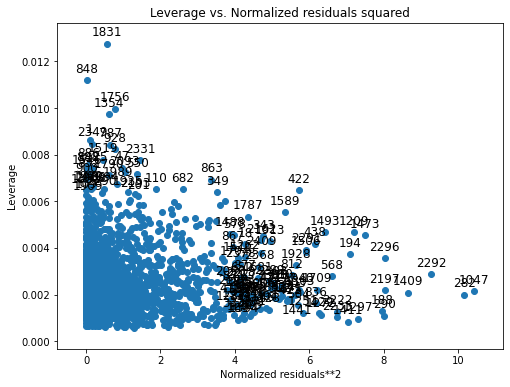

In [26]:
"""
Plot the influence of residuals on the model
"""
test_class = OLSInfluence(model)
test_class.dfbetas[:5, :]
fig, ax = plt.subplots(figsize=(8, 6))
fig = plot_leverage_resid2(model, ax=ax)